In [2]:
from generate_attestations import *

num_wallets = 10
wallet_addresses = generate_wallet_addresses(num_wallets)
attestations = generate_attestations(10,wallet_addresses=wallet_addresses)


In [6]:
attestations[0].attester
wallet_addresses[attestations[0].attester]

{'role': 'dishonest',
 'is_human': False,
 'is_bot': True,
 'creditworthiness': 89}

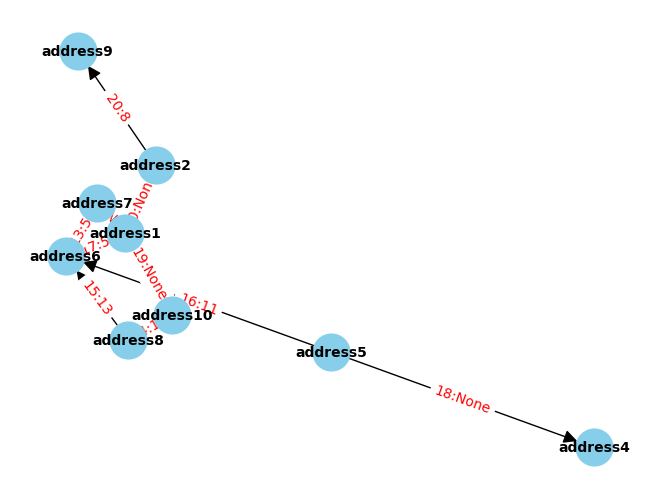

In [8]:
from graphing import *
import networkx as nx
import matplotlib.pyplot as plt

G = create_network_graph(wallet_addresses,attestations)
draw_network_graph(G)

In [9]:
from main import *

linked_attestations = find_linked_attestations_for_identity(attestations,'address1')

print(linked_attestations[0].uid)

3


In [1]:
from calc_trust import *
from generate_attestations import *

num_wallets = 2 
wallet_addresses = generate_wallet_addresses(num_wallets)
attestations = generate_attestations(10,wallet_addresses=wallet_addresses)
linked_attestations_for_identity = find_linked_attestations_for_identity(
                attestations, attestations[0].recipient
            )
trust = calculate_trust(attestations,100)

In [2]:
trust["Ti"]

{'address2': {'creditworthiness': 0.0, 'is_human': 0.0, 'is_bot': 0.9},
 'address1': {'is_human': 0.0, 'creditworthiness': 0.0, 'is_bot': 0.0}}